In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import geopandas as gpd
plt.rcParams['figure.figsize'] = (15,9)
from rasterstats import zonal_stats
from rasterio.transform import Affine
from scipy.interpolate import griddata
import rasterio
from matplotlib.patches import Rectangle

In [2]:
import scipy.stats

In [3]:
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap

In [4]:
shapefile= gpd.read_file('greatlakes_subbasins.shp')

In [5]:
ds1 = xr.open_dataset('zg_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_200001-201412.nc')
hgt = ds1.zg.sel(lat=slice(-10,90), lon=slice(180.5, 360),plev=slice(6) ,time=slice('2010-01-01','2014-12-31'))
lat_zg = ds1.lat.sel(lat=slice(-10,90))
lon_zg = ds1.lon.sel(lon=slice(180.5, 360))

In [6]:
hgt2d = hgt.values
ntime,nlevel, nrow_zg, ncol_zg = hgt2d.shape
print(nrow_zg,ncol_zg)

89 159


In [7]:
a= pd.read_csv("z_anom_mri.csv")
b=pd.read_csv("mri_anom_mean.csv")
b

Unnamed: 0      Erie     Huron  Michigan   Ontario  superior
0            1  2.544854  3.069696  3.455509  2.307835  3.601238
1            2  4.090776  4.191222  3.968049  4.351825  3.620502
2            3  2.294035  2.536471  2.511983  2.471217  2.972928
3            4  3.409514  3.011190  3.727395  3.628956  2.489813
4            5  3.365359  3.837283  3.502696  3.346214  2.569745
5            6  2.630420  3.921495  3.805334  2.653243  2.729829
6            7  2.739429  3.215340  3.308402  3.719279  3.584061
7            8  3.735395  3.835281  3.746430  3.291571  2.757531
8            9  2.991420  2.939966  3.151644  2.769656  3.960650
9           10  4.422192  3.818523  5.031989  3.846549  3.348472
10          11  4.461466  3.604861  4.589660  3.551536  3.185977
11          12  2.603125  3.078028  2.140978  3.367886  2.583565
12          13  3.552360  4.240786  3.859986  3.638961  3.974053
13          14  3.291685  2.949457  3.618576  3.723627  2.623820
14          15  3.290414  2.981023  2.675825  2.877852  2.643448
15          16  2.921907  3.868150  3.847548  3.631726  2.235614
16          17  3.252366  2.532663  3.024990  3.157871  2.439094
17          18  4.243830  3.101521  3.564010  2.645289  2.666907
18          19  2.279159  1.712383  2.509099  1.813697  2.004819
19          20  3.225803  3.358592  3.048810  3.447299  2.717551
20          21  3.060714  3.056449  2.976439  3.149990  2.030948
21          22  4.077812  4.432663  4.449877  4.771212  2.232807
22          23  5.715810  3.684451  2.830433  6.540242  2.537643
23          24  3.104471  3.165238  3.255673  2.973859  2.156929
24          25  3.080970  3.554279  4.526609  3.026098  2.587641
25          26  1.757758  2.991227  2.791265  2.435937  2.180890
26          27  3.046354  3.393557  2.880352  3.654664  1.703263
27          28  3.915641  2.953775  3.382869  3.924124  3.778838
28          29  3.017715  4.075904  3.793946  3.516260  4.162623
29          30  3.944773  3.879049  4.438673  3.594170  2.719923
30          31  2.990104  3.234802  3.947901  2.812513  3.248000
31          32  2.979964  2.144490  2.220082  1.912211  2.628201
32          33  3.710558  3.178275  3.478262  3.597167  2.114882
33          34  3.472020  4.181494  5.219239  4.378188  2.960380
34          35  1.987112  2.625225  2.590703  2.195769  3.708404
35          36  4.951394  3.744986  4.475746  4.393305  2.875374

In [8]:
a= a.drop(['Unnamed: 0'],axis=1)
b= b.drop(['Unnamed: 0'],axis=1)
b['mean']= b.mean(axis=1)
a_t= a.T

In [9]:
a_zg = PCA(n_components=9)
a_zg.fit(a_t)
a_reduced= a_zg.transform(a_t)
zg_f=a_zg.inverse_transform(a_reduced)
print(a_zg.explained_variance_ratio_.sum()) 

0.9156542089319178


In [10]:
rp= np.reshape(zg_f,(nrow_zg,ncol_zg,36),order='F')
range(rp.shape[0])

range(0, 89)

In [11]:
cor_mri= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_mri[:] = np.nan
cor_mri_p= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_mri_p[:] = np.nan

In [12]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_mri[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[0]
        
        
        

In [13]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_mri_p[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[1]
        

In [14]:
mri_sign= np.zeros([89,159])

In [15]:
for i in range(mri_sign.shape[0]):
    for j in range(mri_sign.shape[1]):
        if cor_mri_p[i,j]<0.1:
            mri_sign[i,j]= mri_sign[i,j]+1
        else:
            mri_sign[i,j]= mri_sign[i,j]+0

In [16]:
y,x=np.where(mri_sign>0)


In [17]:
x_list1= x.tolist()
y_list1=y.tolist()
lat_np= lat_zg.to_numpy()
lat_ls= lat_np.tolist()
lon_np=lon_zg.to_numpy()
lon_ls= lon_np.tolist()

In [18]:
lat_list1= []
for values in list(range(len(y_list1))):
    lat_list1.append(lat_ls[y_list1[values]])
    

In [19]:
lon_list1= []
for values in list(range(len(x_list1))):
    lon_list1.append(lon_ls[x_list1[values]])

In [20]:
xmax,ymin,xmin,ymax= shapefile.total_bounds
d1=xmax-xmin
d2=ymax-ymin
rect =Rectangle((xmin, ymin), d1, d2, facecolor="none", ec='k', lw=2)

In [21]:
cor_mri.max()

0.16010296010296013

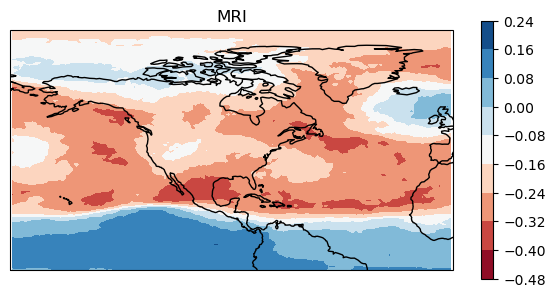

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax2 = fig.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_zg, lat_zg)
level= np.arange(-0.4,0.45,0.05)
cs = ax2.contourf(x1, y1, cor_mri,
                        
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb=fig.colorbar(cs, ax=ax2, shrink=0.8, aspect=20)  
#ax2.scatter(lon_list1,lat_list1,marker='o', color='tab:red')
ax2.coastlines()
ax2.set_global()
ax2.set_extent([-180,0,-7.5,90],crs=ccrs.PlateCarree())
ax2.set_title('MRI')
#ax2.add_patch(rect)


C:\Users\tameem\AppData\Local\Temp\ipykernel_3304\1751899295.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  m.plot(lon_list1,lat_list1,'bo',markersize=1,color='k')


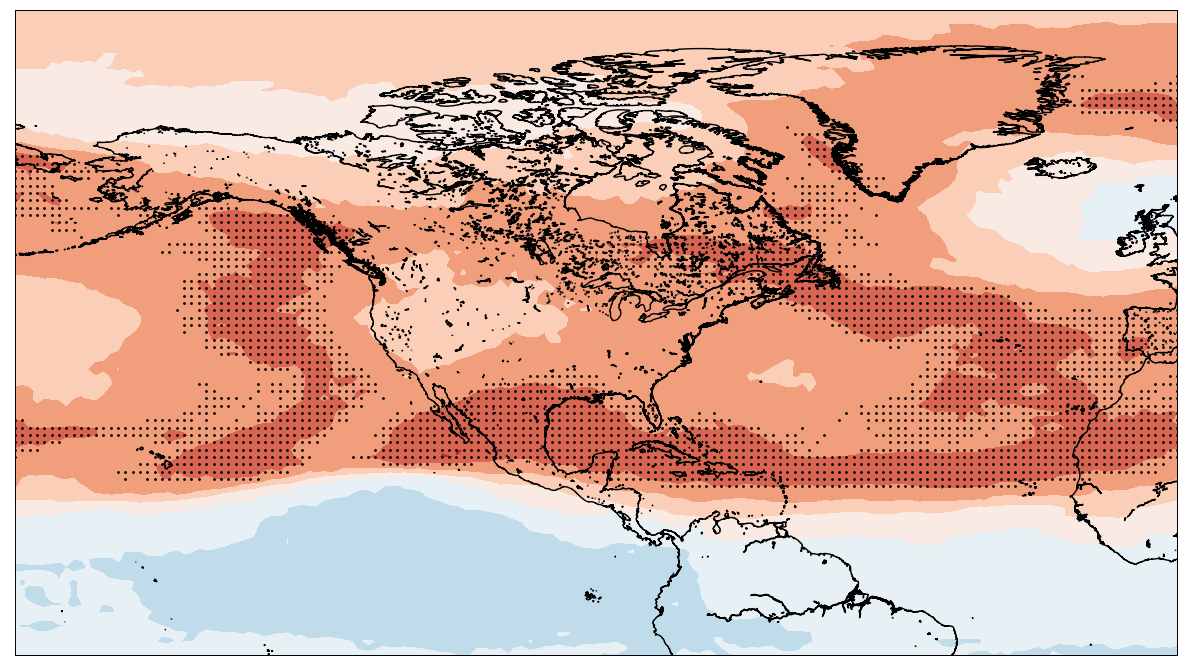

In [26]:
m = Basemap(projection='cyl', llcrnrlon=min(lon_zg), llcrnrlat=min(lat_zg),
        urcrnrlon=max(lon_zg), urcrnrlat=max(lat_zg),resolution='h')

x, y = m(*np.meshgrid(lon_zg,lat_zg))

cs = m.contourf(x,y,cor_mri,np.arange(-0.6,0.7,0.1), cmap='RdBu',extend='both')
m.plot(lon_list1,lat_list1,'bo',markersize=1,color='k')
m.drawcoastlines()
#m.drawcountries()
#cb = m.colorbar(cs)
circle = m.drawmapboundary(fill_color='k',color='k',linewidth=0.7)
circle.set_clip_on(False)
cb.set_label('Correlation Co-efficient')
#plt.title('MRI',size=20)
plt.savefig('PCA_MRI.png')